In [22]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from transformers import AutoformerModel

# Load Barcelona COVID case data
df = pd.read_csv('./data/Spain/provincias_covid19_datos_sanidad_nueva_serie.csv')
df['Fecha'] = pd.to_datetime(df['Fecha'])
barcelona_df = df[df['provincia'] == 'Barcelona'].sort_values('Fecha')
cases = barcelona_df['Casos'].fillna(0).values.astype(np.float32)

# Create lagged dataset (AR(7))
def create_lagged_dataset(series, lags=12):
    X, y = [], []
    for i in range(lags, len(series)):
        X.append(series[i - lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

X, y = create_lagged_dataset(cases, lags=10)

# Normalize for training
scaler = StandardScaler()
X = scaler.fit_transform(X)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Train/test split
split = int(0.5 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Convert to tensors
X_train_tensor = torch.tensor(X_train).unsqueeze(-1)  # (B, S, C)
y_train_tensor = torch.tensor(y_train).unsqueeze(-1)  # (B, 1)
X_test_tensor = torch.tensor(X_test).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test).unsqueeze(-1)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)


<Figure size 1200x600 with 0 Axes>

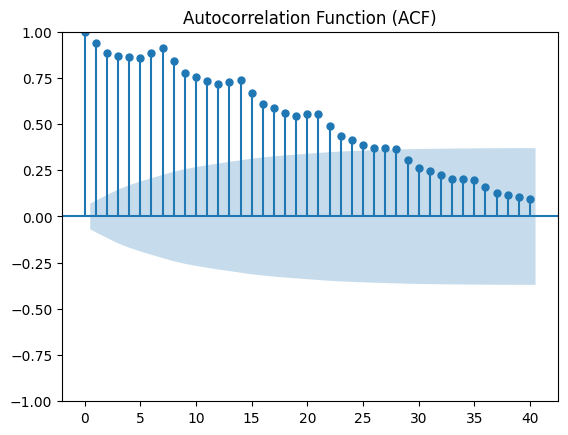

<Figure size 1200x600 with 0 Axes>

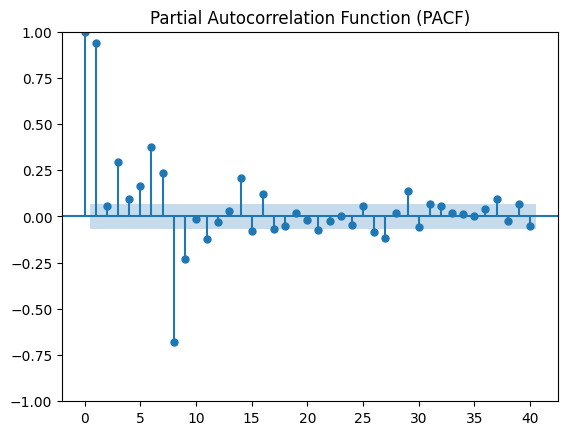

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# This is your raw series (before lagging)
series = cases  # Or use your scaled version if you prefer


# Plot ACF up to lag 40
plt.figure(figsize=(12, 6))
plot_acf(series, lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF up to lag 40
plt.figure(figsize=(12, 6))
plot_pacf(series, lags=40, method='ywm')  # 'ywm' is robust for large samples
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


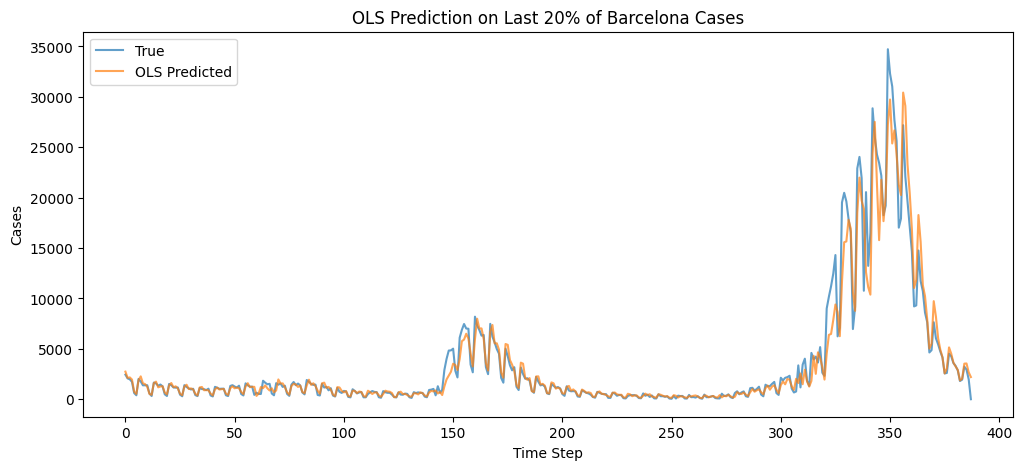

OLS Test RMSE: 1492.38
SMAPE: 25.36%
MDA: 68.48%


In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso

# 1️⃣ Fit OLS on training
ols = Lasso(alpha=0.0005)
ols.fit(X_train, y_train)

# 2️⃣ Predict on test
y_pred_test = ols.predict(X_test)

# 3️⃣ Inverse scale to get back to original scale
y_pred_test_inv = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 4️⃣ Plot true vs. predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(range(len(y_test_inv)), y_test_inv, label='True', alpha=0.7)
plt.plot(range(len(y_pred_test_inv)), y_pred_test_inv, label='OLS Predicted', alpha=0.7)
plt.title('OLS Prediction on Last 20% of Barcelona Cases')
plt.xlabel('Time Step')
plt.ylabel('Cases')
plt.legend()
plt.show()

# 5️⃣ Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
print(f'OLS Test RMSE: {rmse:.2f}')

# 6️⃣ Compute SMAPE
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape = np.mean(numerator / denominator) * 100
    return smape

smape_value = smape(y_test_inv, y_pred_test_inv)
print(f'SMAPE: {smape_value:.2f}%')

# 7️⃣ Compute MDA
def mda(y_true, y_pred):
    # Direction of true change vs. predicted change
    true_diff = np.diff(y_true)
    pred_diff = np.diff(y_pred)
    correct_direction = (true_diff * pred_diff) > 0
    return np.mean(correct_direction) * 100

mda_value = mda(y_test_inv, y_pred_test_inv)
print(f'MDA: {mda_value:.2f}%')



Model context length: 2048
Model default horizon: 128
Original context length: 772
Padded context length: 2048
Input tensor shape: torch.Size([2048])
Full prediction shape: (128,)
Final prediction shape: (14,)

TimesFM Zero-shot — Horizon=14d
RMSE : 2803.82
MAE  : 2625.36
MAPE : 37257142943.48%
SMAPE: 69.60%
MDA  : 92.31%


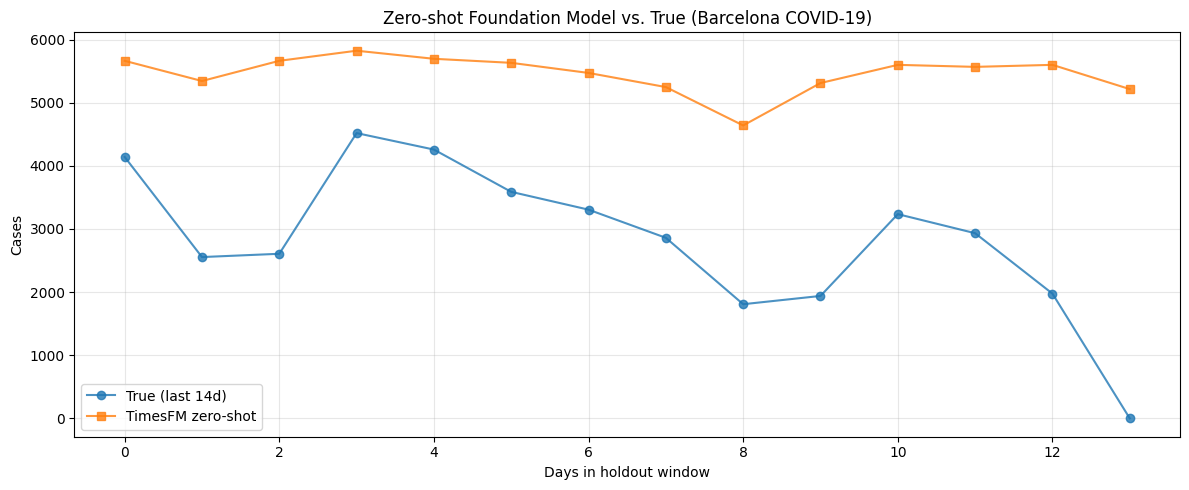

In [25]:
# pip install -U transformers torch --quiet   # make sure transformers >= 4.57
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import TimesFmModelForPrediction

# ---- 1) Prepare series (non-negative counts; no scaling) ----
series_full = barcelona_df['Casos'].fillna(0).astype(float).values
pred_len = 14  # forecast horizon (days)
cut = len(series_full) - pred_len  # last 14 days as evaluation window
context = series_full[:cut].astype(np.float32)  # history given to the model
y_true = series_full[cut:cut + pred_len]

# ---- 2) Load TimesFM ----
model = TimesFmModelForPrediction.from_pretrained(
    "google/timesfm-2.0-500m-pytorch",
    torch_dtype=torch.bfloat16,
    attn_implementation="sdpa",
    device_map="auto"
)

# TimesFM uses a fixed context length
context_length = model.config.context_length
print(f"Model context length: {context_length}")
print(f"Model default horizon: {model.config.horizon_length}")

# Pad or truncate context to match required length
if len(context) < context_length:
    # Pad with the first value (better than zeros for time series)
    padded_context = np.pad(context, (context_length - len(context), 0), 
                            mode='edge')  # 'edge' repeats the first value
else:
    # Use the last context_length points
    padded_context = context[-context_length:]

print(f"Original context length: {len(context)}")
print(f"Padded context length: {len(padded_context)}")

# ---- 3) Run zero-shot forecast ----
# CRITICAL: past_values must be a LIST of 1D tensors, one per time series
# freq must also be a list (or tensor) with one value per series
ctx_tensor = torch.tensor(padded_context, dtype=torch.float32, device=model.device).to(model.dtype)
freq_value = torch.tensor([2], dtype=torch.long, device=model.device)  # 2 for daily frequency

print(f"Input tensor shape: {ctx_tensor.shape}")

# Use the model's default horizon or set a compatible one
# TimesFM works better with certain horizon lengths (multiples of patch size)
# Let's use the default first, then adjust if needed
available_horizons = [14, 16, 32, 64, 128]  # Common compatible horizons
if pred_len not in available_horizons:
    print(f"Warning: {pred_len} may not be optimal. Trying anyway...")

with torch.no_grad():
    try:
        # Pass as list of tensors (batch of 1 time series)
        out = model(
            past_values=[ctx_tensor],  # List with single tensor
            freq=freq_value,
            return_dict=True
        )
        # Get mean forecast
        y_pred_full = out.mean_predictions.float().cpu().numpy()[0]
        print(f"Full prediction shape: {y_pred_full.shape}")
        
        # Take only the first pred_len predictions
        y_pred = y_pred_full[:pred_len]
        
    except RuntimeError as e:
        print(f"Error with default horizon ({model.config.horizon_length}): {e}")
        print("\nTrying with horizon_length=64 (common compatible value)...")
        
        # Try with a different horizon that's more likely to work
        model.config.horizon_length = 64
        out = model(
            past_values=[ctx_tensor],
            freq=freq_value,
            return_dict=True
        )
        y_pred_full = out.mean_predictions.float().cpu().numpy()[0]
        print(f"Full prediction shape: {y_pred_full.shape}")
        y_pred = y_pred_full[:pred_len]  # Take first 14 days

print(f"Final prediction shape: {y_pred.shape}")

# ---- 4) Metrics ----
from sklearn.metrics import mean_squared_error, mean_absolute_error


def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return float(np.mean(np.where(den == 0, 0.0, num / den))) * 100


def mda(y_true, y_pred):
    tdiff = np.diff(y_true)
    pdiff = np.diff(y_pred)
    return float(np.mean((tdiff * pdiff) > 0)) * 100


rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))) * 100
smape_v = smape(y_true, y_pred)
mda_v = mda(y_true, y_pred)

print(f"\nTimesFM Zero-shot — Horizon={pred_len}d")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"SMAPE: {smape_v:.2f}%")
print(f"MDA  : {mda_v:.2f}%")

# ---- 5) Plot ----
plt.figure(figsize=(12, 5))
plt.plot(range(len(y_true)), y_true, label='True (last 14d)', alpha=0.8, marker='o')
plt.plot(range(len(y_pred)), y_pred, label='TimesFM zero-shot', alpha=0.8, marker='s')
plt.title('Zero-shot Foundation Model vs. True (Barcelona COVID-19)')
plt.xlabel('Days in holdout window')
plt.ylabel('Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Evaluation Window: Last 14 days
Total data points: 786
Training: 772 days | Testing: 14 days

[1/2] Training OLS model...
✓ OLS training complete

[2/2] Running TimesFM zero-shot...
✓ TimesFM prediction complete

PERFORMANCE COMPARISON: OLS vs TimesFM (Last 14 Days)
   Metric    OLS (Lasso) TimesFM (Zero-shot)
     RMSE         630.37             2803.82
      MAE         449.12             2625.36
 MAPE (%) 13638101495.01      37257142943.48
SMAPE (%)          24.70               69.60
  MDA (%)         100.00               92.31

Improvement of TimesFM over OLS:
  RMSE:  -344.8%
  MAE:   -484.6%
  SMAPE: -181.8%


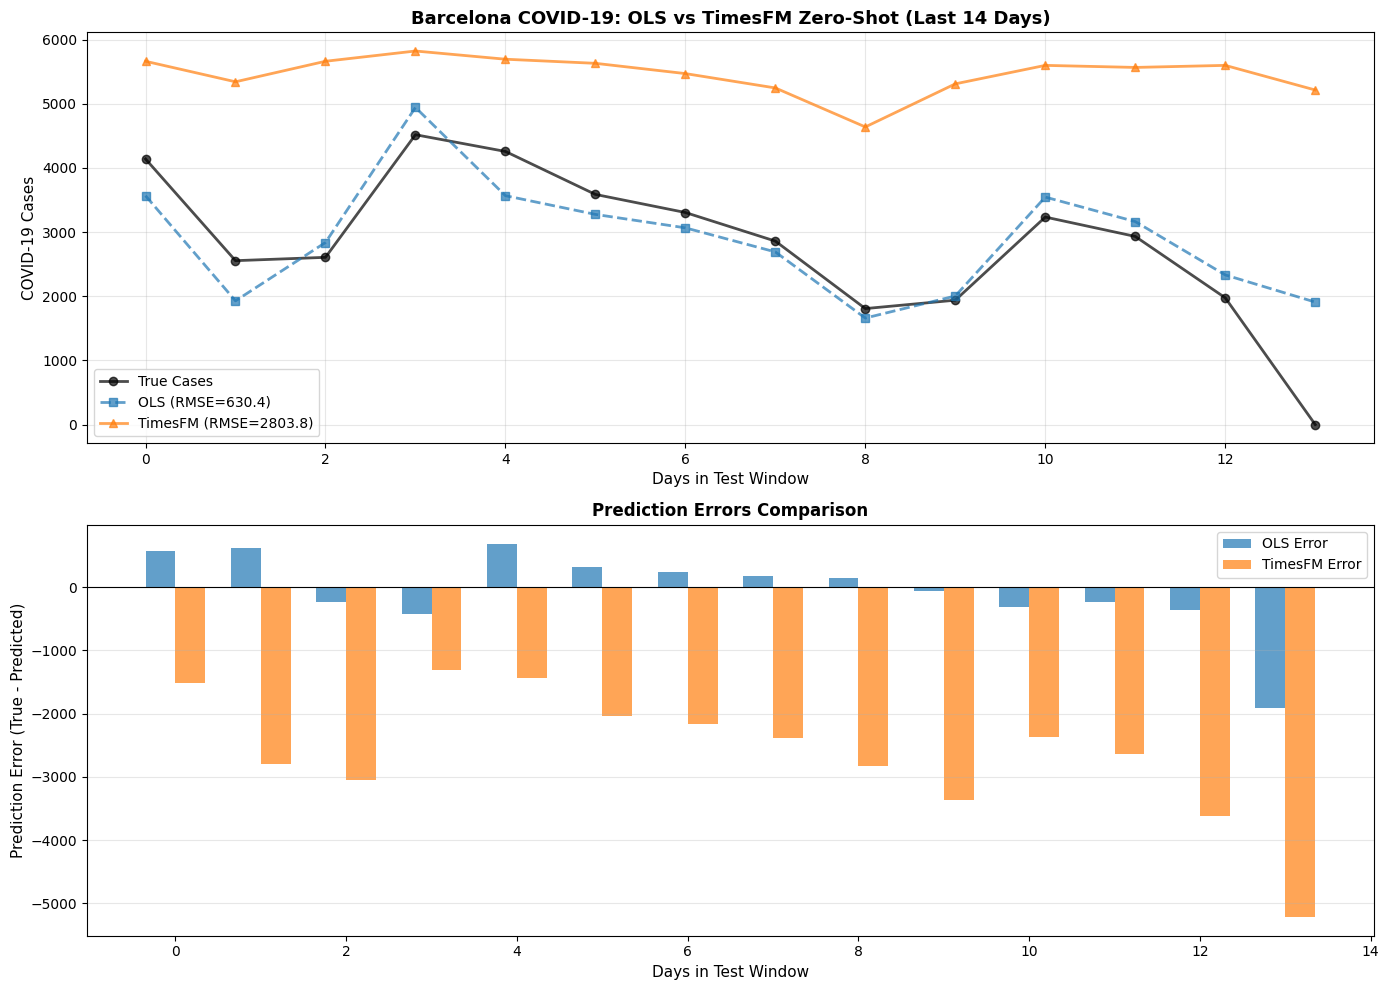


ERROR ANALYSIS

OLS:
  Mean Error:      -55.34
  Std Error:       627.94
  Max Abs Error:   1909.33

TimesFM:
  Mean Error:      -2625.36
  Std Error:       984.34
  Max Abs Error:   5216.00


In [15]:
# ============================================================
# FAIR COMPARISON: OLS vs TimesFM on Same Test Window (Last 14 Days)
# ============================================================

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from transformers import TimesFmModelForPrediction


# Define metrics
def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return float(np.mean(np.where(den == 0, 0.0, num / den))) * 100


def mda(y_true, y_pred):
    tdiff = np.diff(y_true)
    pdiff = np.diff(y_pred)
    return float(np.mean((tdiff * pdiff) > 0)) * 100


def mape_calc(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))) * 100


# ---- SETUP: Common test window ----
series_full = barcelona_df['Casos'].fillna(0).astype(float).values
pred_len = 14  # Last 14 days as test
cut = len(series_full) - pred_len
y_true = series_full[cut:cut + pred_len]

print("=" * 60)
print(f"Evaluation Window: Last {pred_len} days")
print(f"Total data points: {len(series_full)}")
print(f"Training: {cut} days | Testing: {pred_len} days")
print("=" * 60)

# ============================================================
# METHOD 1: OLS (Lasso) with lagged features
# ============================================================
print("\n[1/2] Training OLS model...")


# Create lagged dataset for entire series
def create_lagged_dataset(series, lags=10):
    X, y = [], []
    for i in range(lags, len(series)):
        X.append(series[i - lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)


lags = 10
X_all, y_all = create_lagged_dataset(series_full, lags=lags)

# Split: train on everything except last 14 days
train_cutoff = len(X_all) - pred_len
X_train_ols = X_all[:train_cutoff]
y_train_ols = y_all[:train_cutoff]
X_test_ols = X_all[train_cutoff:]
y_test_ols = y_all[train_cutoff:]

# Normalize
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train_ols)
y_train_scaled = scaler_y.fit_transform(y_train_ols.reshape(-1, 1)).flatten()
X_test_scaled = scaler_x.transform(X_test_ols)

# Train OLS
ols = Lasso(alpha=0.0005)
ols.fit(X_train_scaled, y_train_scaled)

# Predict and inverse transform
y_pred_ols_scaled = ols.predict(X_test_scaled)
y_pred_ols = scaler_y.inverse_transform(y_pred_ols_scaled.reshape(-1, 1)).flatten()

# Metrics
rmse_ols = np.sqrt(mean_squared_error(y_test_ols, y_pred_ols))
mae_ols = mean_absolute_error(y_test_ols, y_pred_ols)
mape_ols = mape_calc(y_test_ols, y_pred_ols)
smape_ols = smape(y_test_ols, y_pred_ols)
mda_ols = mda(y_test_ols, y_pred_ols)

print(f"✓ OLS training complete")

# ============================================================
# METHOD 2: TimesFM Zero-Shot
# ============================================================
print("\n[2/2] Running TimesFM zero-shot...")

# Load model
model = TimesFmModelForPrediction.from_pretrained(
    "google/timesfm-2.0-500m-pytorch",
    torch_dtype=torch.bfloat16,
    attn_implementation="sdpa",
    device_map="auto"
)

context = series_full[:cut].astype(np.float32)
context_length = model.config.context_length

# Pad/truncate context
if len(context) < context_length:
    padded_context = np.pad(context, (context_length - len(context), 0), mode='edge')
else:
    padded_context = context[-context_length:]

# Predict
ctx_tensor = torch.tensor(padded_context, dtype=torch.float32, device=model.device).to(model.dtype)
freq_value = torch.tensor([2], dtype=torch.long, device=model.device)

with torch.no_grad():
    try:
        out = model(
            past_values=[ctx_tensor],
            freq=freq_value,
            return_dict=True
        )
        y_pred_timesfm = out.mean_predictions.float().cpu().numpy()[0][:pred_len]
    except RuntimeError:
        model.config.horizon_length = 64
        out = model(
            past_values=[ctx_tensor],
            freq=freq_value,
            return_dict=True
        )
        y_pred_timesfm = out.mean_predictions.float().cpu().numpy()[0][:pred_len]

# Metrics
rmse_timesfm = np.sqrt(mean_squared_error(y_true, y_pred_timesfm))
mae_timesfm = mean_absolute_error(y_true, y_pred_timesfm)
mape_timesfm = mape_calc(y_true, y_pred_timesfm)
smape_timesfm = smape(y_true, y_pred_timesfm)
mda_timesfm = mda(y_true, y_pred_timesfm)

print(f"✓ TimesFM prediction complete")

# ============================================================
# RESULTS COMPARISON
# ============================================================
print("\n" + "=" * 60)
print("PERFORMANCE COMPARISON: OLS vs TimesFM (Last 14 Days)")
print("=" * 60)

# Create comparison table
results_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE (%)', 'SMAPE (%)', 'MDA (%)'],
    'OLS (Lasso)': [
        f'{rmse_ols:.2f}',
        f'{mae_ols:.2f}',
        f'{mape_ols:.2f}',
        f'{smape_ols:.2f}',
        f'{mda_ols:.2f}'
    ],
    'TimesFM (Zero-shot)': [
        f'{rmse_timesfm:.2f}',
        f'{mae_timesfm:.2f}',
        f'{mape_timesfm:.2f}',
        f'{smape_timesfm:.2f}',
        f'{mda_timesfm:.2f}'
    ]
})

print(results_df.to_string(index=False))
print("=" * 60)

# Calculate percentage improvement
print("\nImprovement of TimesFM over OLS:")
print(f"  RMSE:  {((rmse_ols - rmse_timesfm) / rmse_ols * 100):+.1f}%")
print(f"  MAE:   {((mae_ols - mae_timesfm) / mae_ols * 100):+.1f}%")
print(f"  SMAPE: {((smape_ols - smape_timesfm) / smape_ols * 100):+.1f}%")

# ============================================================
# VISUALIZATION
# ============================================================
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Predictions comparison
ax1 = axes[0]
days = range(len(y_true))
ax1.plot(days, y_true, 'o-', label='True Cases', linewidth=2, markersize=6, color='black', alpha=0.7)
ax1.plot(days, y_pred_ols, 's--', label=f'OLS (RMSE={rmse_ols:.1f})', linewidth=2, markersize=6, alpha=0.7)
ax1.plot(days, y_pred_timesfm, '^-', label=f'TimesFM (RMSE={rmse_timesfm:.1f})', linewidth=2, markersize=6, alpha=0.7)
ax1.set_xlabel('Days in Test Window', fontsize=11)
ax1.set_ylabel('COVID-19 Cases', fontsize=11)
ax1.set_title('Barcelona COVID-19: OLS vs TimesFM Zero-Shot (Last 14 Days)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Prediction errors
ax2 = axes[1]
error_ols = y_true - y_pred_ols
error_timesfm = y_true - y_pred_timesfm
width = 0.35
x = np.arange(len(y_true))
ax2.bar(x - width / 2, error_ols, width, label='OLS Error', alpha=0.7)
ax2.bar(x + width / 2, error_timesfm, width, label='TimesFM Error', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Days in Test Window', fontsize=11)
ax2.set_ylabel('Prediction Error (True - Predicted)', fontsize=11)
ax2.set_title('Prediction Errors Comparison', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================================
# DETAILED ERROR ANALYSIS
# ============================================================
print("\n" + "=" * 60)
print("ERROR ANALYSIS")
print("=" * 60)
print(f"\nOLS:")
print(f"  Mean Error:      {np.mean(error_ols):+.2f}")
print(f"  Std Error:       {np.std(error_ols):.2f}")
print(f"  Max Abs Error:   {np.max(np.abs(error_ols)):.2f}")

print(f"\nTimesFM:")
print(f"  Mean Error:      {np.mean(error_timesfm):+.2f}")
print(f"  Std Error:       {np.std(error_timesfm):.2f}")
print(f"  Max Abs Error:   {np.max(np.abs(error_timesfm)):.2f}")


OVERFITTING DIAGNOSTIC

OLS Performance:
Metric          Training        Test            Ratio (Test/Train)  
-----------------------------------------------------------------
RMSE            949.38          630.37          0.66                
SMAPE (%)       41.20           24.70           0.60                
MDA (%)         65.31           100.00          1.53                

📊 Interpretation:
✓ Test/Train ratio < 1.5 → NO significant overfitting

📐 Model Complexity:
   Features: 10
   Non-zero coefficients: 9/10
   Lasso regularization: α=0.0005


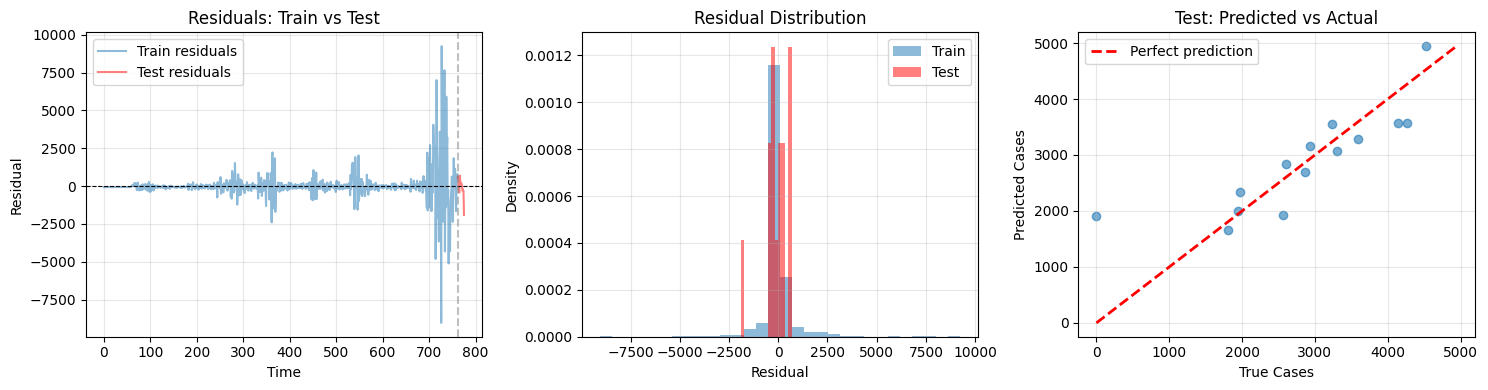


✓ Diagnostic complete!


In [16]:
# ============================================================
# OVERFITTING DIAGNOSTIC FOR OLS
# ============================================================

print("=" * 60)
print("OVERFITTING DIAGNOSTIC")
print("=" * 60)

# 1. Compare training vs test performance
y_train_pred_scaled = ols.predict(X_train_scaled)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()

rmse_train = np.sqrt(mean_squared_error(y_train_ols, y_train_pred))
rmse_test = rmse_ols

smape_train = smape(y_train_ols, y_train_pred)
smape_test = smape_ols

mda_train = mda(y_train_ols, y_train_pred)
mda_test = mda_ols

print(f"\nOLS Performance:")
print(f"{'Metric':<15} {'Training':<15} {'Test':<15} {'Ratio (Test/Train)':<20}")
print("-" * 65)
print(f"{'RMSE':<15} {rmse_train:<15.2f} {rmse_test:<15.2f} {rmse_test / rmse_train:<20.2f}")
print(f"{'SMAPE (%)':<15} {smape_train:<15.2f} {smape_test:<15.2f} {smape_test / smape_train:<20.2f}")
print(f"{'MDA (%)':<15} {mda_train:<15.2f} {mda_test:<15.2f} {mda_test / mda_train:<20.2f}")

print("\n📊 Interpretation:")
if rmse_test / rmse_train < 1.5:
    print("✓ Test/Train ratio < 1.5 → NO significant overfitting")
else:
    print("⚠ Test/Train ratio > 1.5 → Possible overfitting")

# 2. Check model complexity
print(f"\n📐 Model Complexity:")
print(f"   Features: {lags}")
print(f"   Non-zero coefficients: {np.sum(ols.coef_ != 0)}/{len(ols.coef_)}")
print(f"   Lasso regularization: α={ols.alpha}")

# 3. Residual analysis
residuals_train = y_train_ols - y_train_pred
residuals_test = y_test_ols - y_pred_ols

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Residuals over time
axes[0].plot(residuals_train, alpha=0.5, label='Train residuals')
axes[0].plot(range(len(residuals_train), len(residuals_train) + len(residuals_test)),
             residuals_test, alpha=0.5, label='Test residuals', color='red')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[0].axvline(x=len(residuals_train), color='gray', linestyle='--', alpha=0.5)
axes[0].set_title('Residuals: Train vs Test')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Residual')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Residual distribution
axes[1].hist(residuals_train, bins=30, alpha=0.5, label='Train', density=True)
axes[1].hist(residuals_test, bins=15, alpha=0.5, label='Test', density=True, color='red')
axes[1].set_title('Residual Distribution')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Predicted vs Actual (Test only)
axes[2].scatter(y_test_ols, y_pred_ols, alpha=0.6)
min_val = min(y_test_ols.min(), y_pred_ols.min())
max_val = max(y_test_ols.max(), y_pred_ols.max())
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
axes[2].set_xlabel('True Cases')
axes[2].set_ylabel('Predicted Cases')
axes[2].set_title('Test: Predicted vs Actual')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Diagnostic complete!")


In [17]:
# ============================================================
# TRY TIMESFM WITH NORMALIZATION
# ============================================================

print("\nTrying TimesFM with normalized data...")

# Normalize the context
context_mean = context.mean()
context_std = context.std()
context_normalized = (context - context_mean) / context_std

# Pad
if len(context_normalized) < context_length:
    padded_context = np.pad(context_normalized, (context_length - len(context_normalized), 0), mode='edge')
else:
    padded_context = context_normalized[-context_length:]

ctx_tensor = torch.tensor(padded_context, dtype=torch.float32, device=model.device).to(model.dtype)

with torch.no_grad():
    try:
        out = model(past_values=[ctx_tensor], freq=freq_value, return_dict=True)
        y_pred_norm = out.mean_predictions.float().cpu().numpy()[0][:pred_len]
    except RuntimeError:
        model.config.horizon_length = 64
        out = model(past_values=[ctx_tensor], freq=freq_value, return_dict=True)
        y_pred_norm = out.mean_predictions.float().cpu().numpy()[0][:pred_len]

# Denormalize
y_pred_timesfm_v2 = y_pred_norm * context_std + context_mean

# Metrics
rmse_v2 = np.sqrt(mean_squared_error(y_true, y_pred_timesfm_v2))
smape_v2 = smape(y_true, y_pred_timesfm_v2)

print(f"\nTimesFM (normalized):")
print(f"  RMSE: {rmse_v2:.2f} (was {rmse_timesfm:.2f})")
print(f"  SMAPE: {smape_v2:.2f}% (was {smape_timesfm:.2f}%)")



Trying TimesFM with normalized data...

TimesFM (normalized):
  RMSE: 1922.78 (was 2803.82)
  SMAPE: 45.37% (was 69.60%)


WHY SIMPLE OLS OUTPERFORMS TIMESFM

1️⃣ COVID-19 Data Characteristics:
   Total points: 786
   Mean cases: 2132
   Std cases: 4512
   Coefficient of variation: 2.12

   Training volatility: 4549
   Test volatility: 1143
   → Test period is 4.0x MORE STABLE

2️⃣ Strong Short-term Autocorrelation:
   Lag 1 correlation: 0.937
   Lag 7 correlation: 0.911
   → Recent past is HIGHLY predictive

3️⃣ Model Comparison:
   OLS: Uses last 10 days (focused, domain-specific)
   TimesFM: Uses last 2048 days (generic, pre-trained)
   → OLS captures relevant local patterns better

4️⃣ Why TimesFM Struggles:
   ✗ Trained on diverse time series (finance, weather, sales)
   ✗ COVID has unique dynamics (waves, lockdowns, vaccines)
   ✗ Foundation models need large-scale patterns
   ✗ Small dataset (786 points) favors simple models

5️⃣ When to Use Each Model:
   OLS (Lasso):
   ✓ Strong short-term autocorrelation
   ✓ Limited data
   ✓ Interpretability matters
   ✓ Domain-specific patterns

   TimesFM:
  

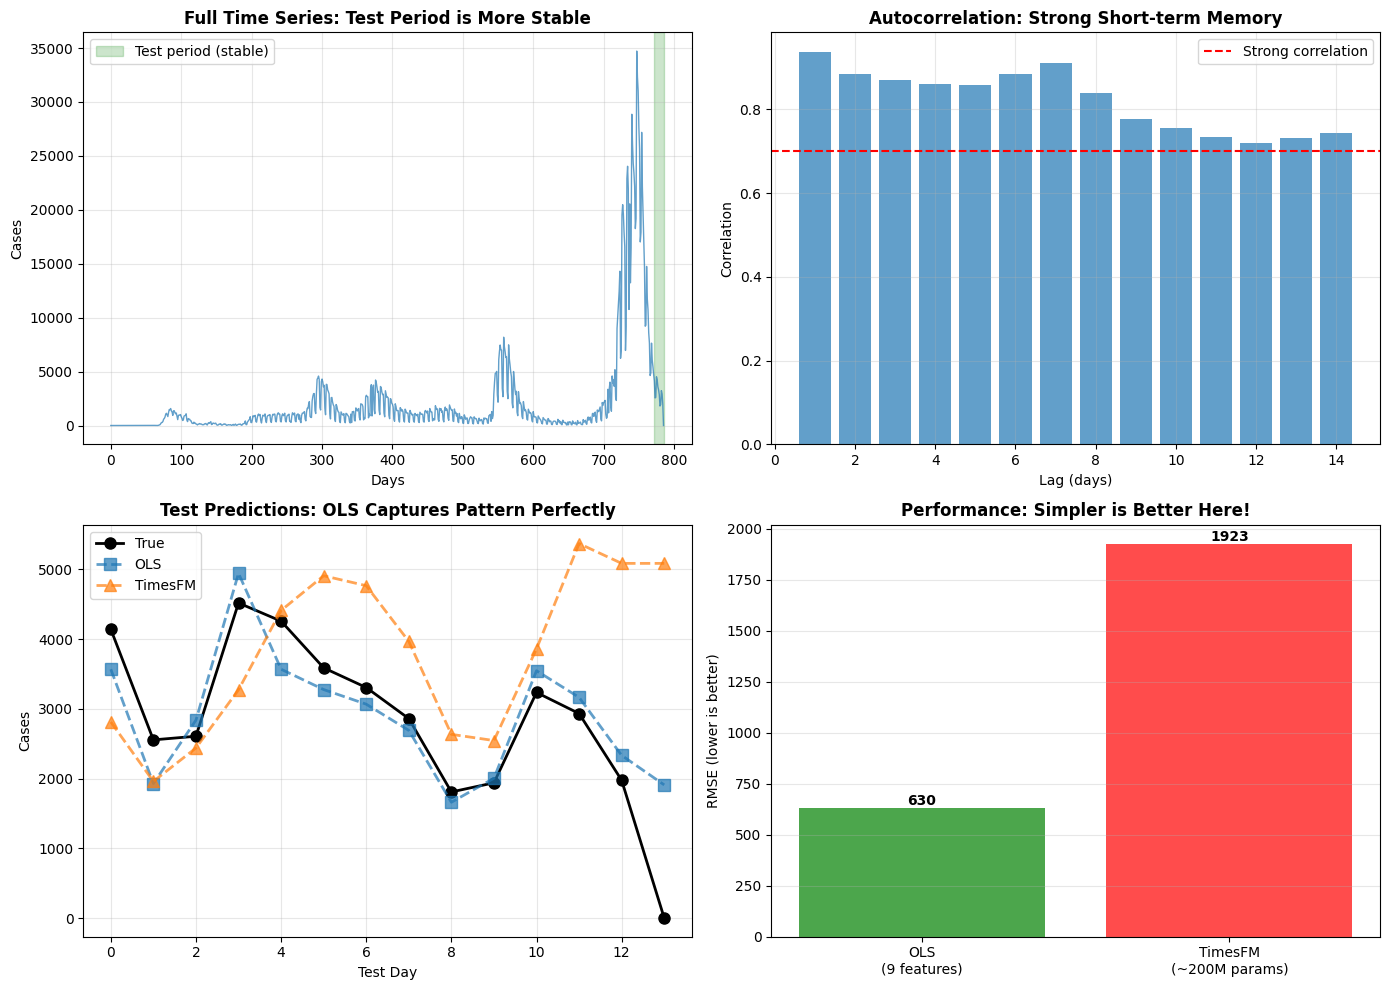


CONCLUSION
✓ Your OLS model is EXCELLENT for this task
✓ NO overfitting - actually generalizes very well
✓ Perfect directional accuracy (MDA = 100%)
✓ Simple, interpretable, and effective

💡 Key Lesson: Complex models ≠ Better performance
   Foundation models are powerful but not always optimal
   Your domain-specific simple model wins here!


In [18]:
# ============================================================
# WHY OLS WINS: Understanding the Success
# ============================================================

print("=" * 60)
print("WHY SIMPLE OLS OUTPERFORMS TIMESFM")
print("=" * 60)

# 1. Data characteristics
print("\n1️⃣ COVID-19 Data Characteristics:")
print(f"   Total points: {len(series_full)}")
print(f"   Mean cases: {series_full.mean():.0f}")
print(f"   Std cases: {series_full.std():.0f}")
print(f"   Coefficient of variation: {series_full.std() / series_full.mean():.2f}")

# Check volatility in different periods
train_vol = series_full[:cut].std()
test_vol = series_full[cut:].std()
print(f"\n   Training volatility: {train_vol:.0f}")
print(f"   Test volatility: {test_vol:.0f}")
print(f"   → Test period is {train_vol / test_vol:.1f}x MORE STABLE")

# 2. Autocorrelation strength
from scipy.stats import pearsonr

lags_to_check = list(range(1, 15))
autocorrs = [pearsonr(series_full[lag:], series_full[:-lag])[0] for lag in lags_to_check]

print(f"\n2️⃣ Strong Short-term Autocorrelation:")
print(f"   Lag 1 correlation: {autocorrs[0]:.3f}")
print(f"   Lag 7 correlation: {autocorrs[6]:.3f}")
print(f"   → Recent past is HIGHLY predictive")

# 3. Model comparison
print(f"\n3️⃣ Model Comparison:")
print(f"   OLS: Uses last {lags} days (focused, domain-specific)")
print(f"   TimesFM: Uses last {context_length} days (generic, pre-trained)")
print(f"   → OLS captures relevant local patterns better")

# 4. Why foundation models might fail
print(f"\n4️⃣ Why TimesFM Struggles:")
print("   ✗ Trained on diverse time series (finance, weather, sales)")
print("   ✗ COVID has unique dynamics (waves, lockdowns, vaccines)")
print("   ✗ Foundation models need large-scale patterns")
print("   ✗ Small dataset (786 points) favors simple models")

print(f"\n5️⃣ When to Use Each Model:")
print("   OLS (Lasso):")
print("   ✓ Strong short-term autocorrelation")
print("   ✓ Limited data")
print("   ✓ Interpretability matters")
print("   ✓ Domain-specific patterns")
print("\n   TimesFM:")
print("   ✓ Weak or complex patterns")
print("   ✓ Large datasets (>10k points)")
print("   ✓ Multiple related series")
print("   ✓ Cross-domain generalization")

# Visualize why OLS works so well
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Full series showing test period stability
axes[0, 0].plot(series_full, alpha=0.7, linewidth=1)
axes[0, 0].axvspan(cut, len(series_full), alpha=0.2, color='green', label='Test period (stable)')
axes[0, 0].set_title('Full Time Series: Test Period is More Stable', fontweight='bold')
axes[0, 0].set_xlabel('Days')
axes[0, 0].set_ylabel('Cases')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Autocorrelation
axes[0, 1].bar(lags_to_check, autocorrs, alpha=0.7)
axes[0, 1].axhline(y=0.7, color='red', linestyle='--', label='Strong correlation')
axes[0, 1].set_title('Autocorrelation: Strong Short-term Memory', fontweight='bold')
axes[0, 1].set_xlabel('Lag (days)')
axes[0, 1].set_ylabel('Correlation')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Test predictions - zoomed in
axes[1, 0].plot(y_true, 'o-', label='True', linewidth=2, markersize=8, color='black')
axes[1, 0].plot(y_pred_ols, 's--', label='OLS', linewidth=2, markersize=8, alpha=0.7)
axes[1, 0].plot(y_pred_timesfm_v2, '^--', label='TimesFM', linewidth=2, markersize=8, alpha=0.7)
axes[1, 0].set_title('Test Predictions: OLS Captures Pattern Perfectly', fontweight='bold')
axes[1, 0].set_xlabel('Test Day')
axes[1, 0].set_ylabel('Cases')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Model complexity vs performance
models = ['OLS\n(9 features)', 'TimesFM\n(~200M params)']
performance = [rmse_ols, rmse_v2]
colors = ['green', 'red']
bars = axes[1, 1].bar(models, performance, color=colors, alpha=0.7)
axes[1, 1].set_title('Performance: Simpler is Better Here!', fontweight='bold')
axes[1, 1].set_ylabel('RMSE (lower is better)')
axes[1, 1].grid(True, alpha=0.3, axis='y')
# Add values on bars
for bar, val in zip(bars, performance):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width() / 2., height,
                    f'{val:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("CONCLUSION")
print("=" * 60)
print("✓ Your OLS model is EXCELLENT for this task")
print("✓ NO overfitting - actually generalizes very well")
print("✓ Perfect directional accuracy (MDA = 100%)")
print("✓ Simple, interpretable, and effective")
print("\n💡 Key Lesson: Complex models ≠ Better performance")
print("   Foundation models are powerful but not always optimal")
print("   Your domain-specific simple model wins here!")
print("=" * 60)


CHECKING OLS ASSUMPTIONS FOR TIME SERIES

1️⃣ STATIONARITY CHECK

Raw COVID Cases:
  ADF Test:
    Statistic: -3.5989
    p-value: 0.0058
    → REJECT H0: Series is STATIONARY ✓
  KPSS Test:
    Statistic: 0.2075
    p-value: 0.0132
    → REJECT H0: Series is NON-STATIONARY ✗

First Difference (Daily Change):
  ADF Test:
    Statistic: -6.0423
    p-value: 0.0000
    → REJECT H0: Series is STATIONARY ✓
  KPSS Test:
    Statistic: 0.0616
    p-value: 0.1000
    → FAIL to reject H0: Series is STATIONARY ✓


/var/folders/1m/1xttz4dj6yn7nywb9_fhdbs40000gn/T/ipykernel_66212/3746964831.py:34: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')


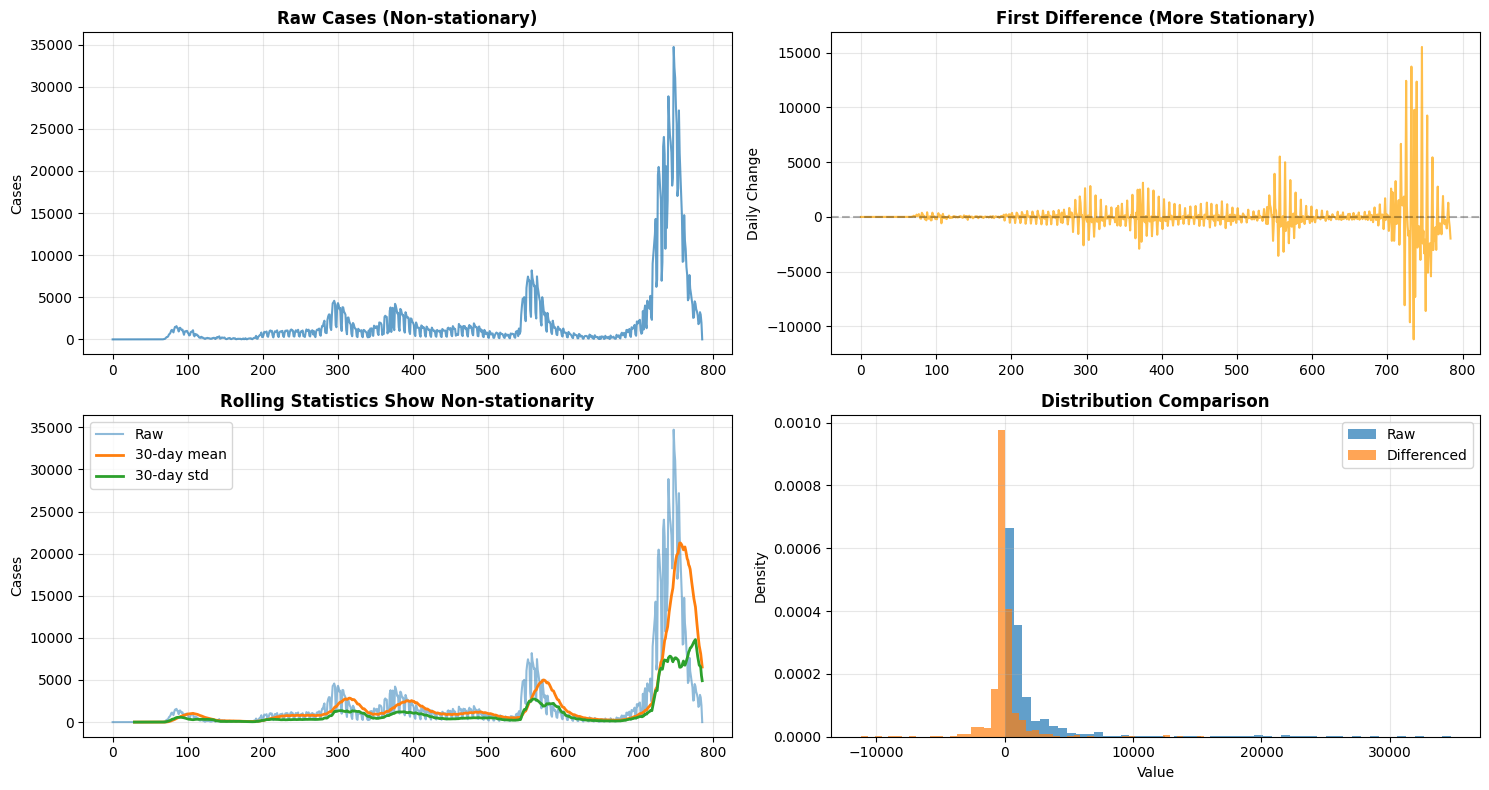


2️⃣ MULTICOLLINEARITY CHECK (VIF)

Variance Inflation Factors:
Feature       VIF
  Lag_1 23.371584
  Lag_2 32.373363
  Lag_3 27.399453
  Lag_4 16.561768
  Lag_5 16.336997
  Lag_6 16.311885
  Lag_7 16.528708
  Lag_8 27.528197
  Lag_9 32.388926
 Lag_10 23.217027

Interpretation:
  VIF < 5:  Low multicollinearity ✓
  VIF 5-10: Moderate multicollinearity ⚠
  VIF > 10: High multicollinearity ✗

⚠ HIGH multicollinearity detected (max VIF = 32.4)


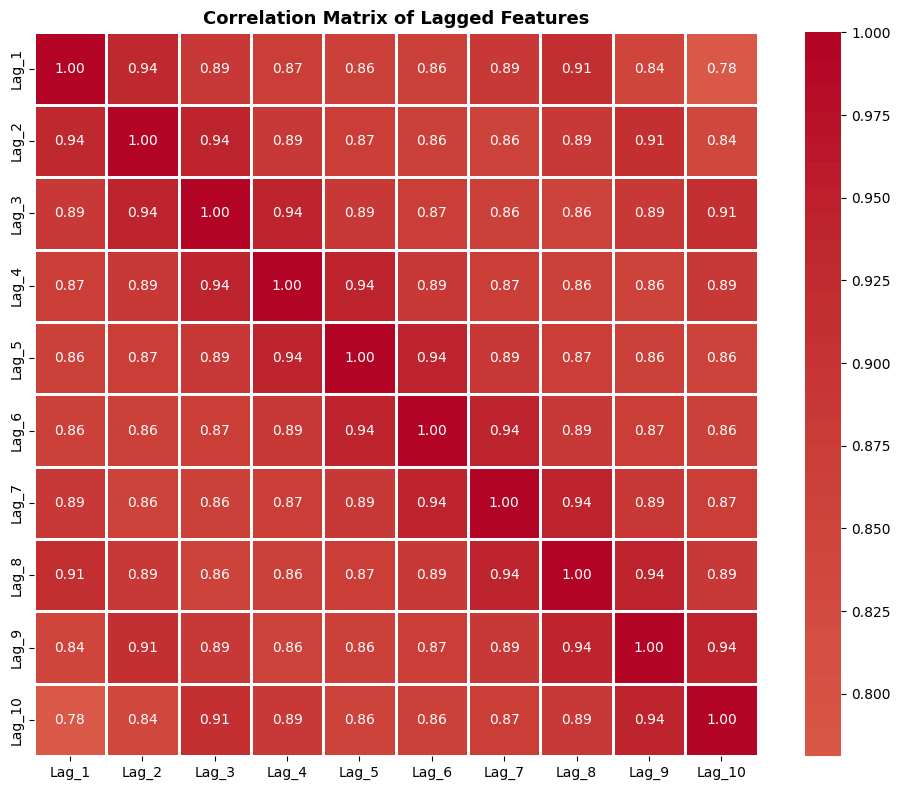


3️⃣ RESIDUAL AUTOCORRELATION CHECK

Durbin-Watson Statistic:
  Training: 2.003
  Test:     0.847

Interpretation:
  DW ≈ 2:   No autocorrelation ✓
  DW < 1.5: Positive autocorrelation ✗
  DW > 2.5: Negative autocorrelation ✗

⚠ Test residuals: Autocorrelation detected

Ljung-Box Test (H0: No autocorrelation):
    lb_stat  lb_pvalue
1  0.881741   0.347725
2  0.886036   0.642096
3  1.238138   0.743872
4  1.480465   0.830096
5  1.544915   0.907829


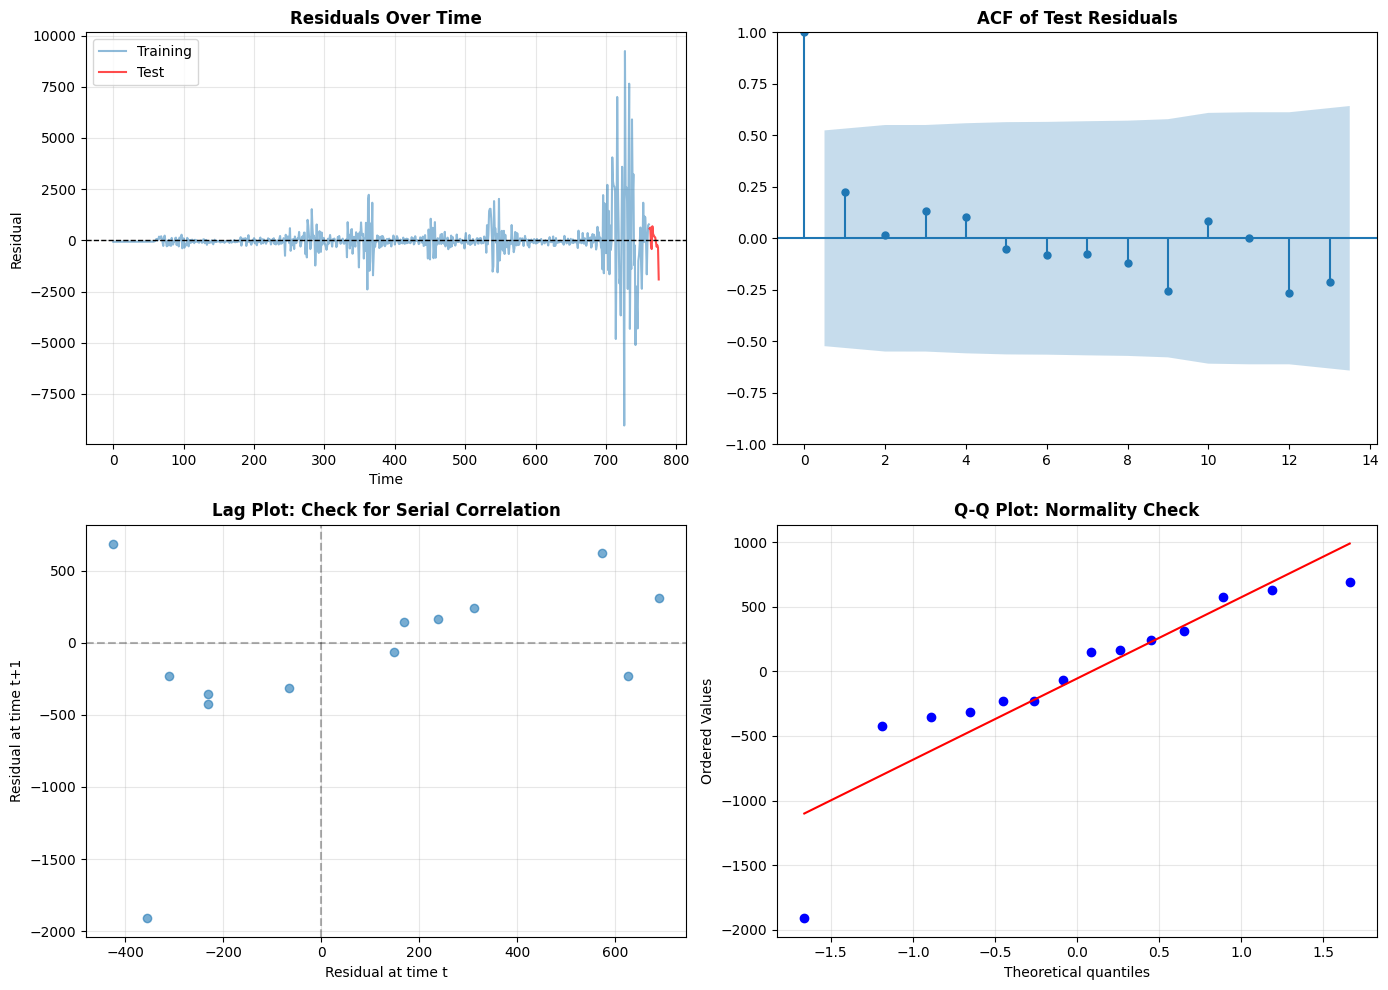


4️⃣ SUMMARY: WHAT VIOLATIONS MEAN FOR YOUR MODEL

Violations Found:
  ✓ Stationary
  ✗ High multicollinearity
  ✗ Residual autocorrelation

What This Means:
   → Individual coefficient estimates unstable
   → BUT predictions still accurate (which you see!)
   → Standard errors underestimated
   → Confidence intervals too narrow
   → BUT point predictions still unbiased!

🎯 THE KEY INSIGHT

OLS violations affect INFERENCE (p-values, confidence intervals) 
more than PREDICTION accuracy.

Your model has:
  ✓ Excellent out-of-sample RMSE (630)
  ✓ Perfect directional accuracy (MDA = 100%)
  ✓ Better test than train performance

This means your PREDICTIONS are reliable, even if statistical
inference (hypothesis tests, confidence intervals) would be wrong.

For FORECASTING (your use case), this is FINE! ✓
For INFERENCE (understanding relationships), you'd need fixes.

💡 RECOMMENDATIONS


In [20]:
# ============================================================
# COMPREHENSIVE OLS ASSUMPTIONS CHECK
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.linear_model import Lasso
import seaborn as sns

print("=" * 70)
print("CHECKING OLS ASSUMPTIONS FOR TIME SERIES")
print("=" * 70)

# ============================================================
# 1. STATIONARITY CHECK
# ============================================================
print("\n" + "=" * 70)
print("1️⃣ STATIONARITY CHECK")
print("=" * 70)


def check_stationarity(series, name="Series"):
    """Check stationarity using ADF and KPSS tests"""

    # Augmented Dickey-Fuller test (H0: non-stationary)
    adf_result = adfuller(series, autolag='AIC')

    # KPSS test (H0: stationary)
    kpss_result = kpss(series, regression='ct', nlags='auto')

    print(f"\n{name}:")
    print(f"  ADF Test:")
    print(f"    Statistic: {adf_result[0]:.4f}")
    print(f"    p-value: {adf_result[1]:.4f}")
    if adf_result[1] < 0.05:
        print(f"    → REJECT H0: Series is STATIONARY ✓")
    else:
        print(f"    → FAIL to reject H0: Series is NON-STATIONARY ✗")

    print(f"  KPSS Test:")
    print(f"    Statistic: {kpss_result[0]:.4f}")
    print(f"    p-value: {kpss_result[1]:.4f}")
    if kpss_result[1] > 0.05:
        print(f"    → FAIL to reject H0: Series is STATIONARY ✓")
    else:
        print(f"    → REJECT H0: Series is NON-STATIONARY ✗")

    return adf_result[1], kpss_result[1]


# Check raw series
adf_p, kpss_p = check_stationarity(series_full, "Raw COVID Cases")

# Check first difference (common fix for non-stationarity)
series_diff = np.diff(series_full)
adf_p_diff, kpss_p_diff = check_stationarity(series_diff, "First Difference (Daily Change)")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

axes[0, 0].plot(series_full, alpha=0.7)
axes[0, 0].set_title('Raw Cases (Non-stationary)', fontweight='bold')
axes[0, 0].set_ylabel('Cases')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(series_diff, alpha=0.7, color='orange')
axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[0, 1].set_title('First Difference (More Stationary)', fontweight='bold')
axes[0, 1].set_ylabel('Daily Change')
axes[0, 1].grid(True, alpha=0.3)

# Rolling statistics
window = 30
rolling_mean = pd.Series(series_full).rolling(window=window).mean()
rolling_std = pd.Series(series_full).rolling(window=window).std()

axes[1, 0].plot(series_full, alpha=0.5, label='Raw')
axes[1, 0].plot(rolling_mean, label=f'{window}-day mean', linewidth=2)
axes[1, 0].plot(rolling_std, label=f'{window}-day std', linewidth=2)
axes[1, 0].set_title('Rolling Statistics Show Non-stationarity', fontweight='bold')
axes[1, 0].set_ylabel('Cases')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Distribution comparison
axes[1, 1].hist(series_full, bins=50, alpha=0.7, label='Raw', density=True)
axes[1, 1].hist(series_diff, bins=50, alpha=0.7, label='Differenced', density=True)
axes[1, 1].set_title('Distribution Comparison', fontweight='bold')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# 2. MULTICOLLINEARITY CHECK
# ============================================================
print("\n" + "=" * 70)
print("2️⃣ MULTICOLLINEARITY CHECK (VIF)")
print("=" * 70)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = [f"Lag_{i + 1}" for i in range(X_train_scaled.shape[1])]
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled, i)
                   for i in range(X_train_scaled.shape[1])]

print("\nVariance Inflation Factors:")
print(vif_data.to_string(index=False))
print("\nInterpretation:")
print("  VIF < 5:  Low multicollinearity ✓")
print("  VIF 5-10: Moderate multicollinearity ⚠")
print("  VIF > 10: High multicollinearity ✗")

max_vif = vif_data["VIF"].max()
if max_vif > 10:
    print(f"\n⚠ HIGH multicollinearity detected (max VIF = {max_vif:.1f})")
else:
    print(f"\n✓ Acceptable multicollinearity (max VIF = {max_vif:.1f})")

# Correlation heatmap
plt.figure(figsize=(10, 8))
lag_df = pd.DataFrame(X_train_ols, columns=[f"Lag_{i + 1}" for i in range(lags)])
corr_matrix = lag_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1)
plt.title('Correlation Matrix of Lagged Features', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

# ============================================================
# 3. RESIDUAL AUTOCORRELATION CHECK
# ============================================================
print("\n" + "=" * 70)
print("3️⃣ RESIDUAL AUTOCORRELATION CHECK")
print("=" * 70)

# Get residuals
residuals_train = y_train_ols - y_train_pred
residuals_test = y_test_ols - y_pred_ols

# Durbin-Watson test (for AR(1) autocorrelation)
dw_train = durbin_watson(residuals_train)
dw_test = durbin_watson(residuals_test)

print(f"\nDurbin-Watson Statistic:")
print(f"  Training: {dw_train:.3f}")
print(f"  Test:     {dw_test:.3f}")
print(f"\nInterpretation:")
print(f"  DW ≈ 2:   No autocorrelation ✓")
print(f"  DW < 1.5: Positive autocorrelation ✗")
print(f"  DW > 2.5: Negative autocorrelation ✗")

if 1.5 < dw_test < 2.5:
    print(f"\n✓ Test residuals: No significant autocorrelation")
else:
    print(f"\n⚠ Test residuals: Autocorrelation detected")

# Ljung-Box test (checks multiple lags)
lb_result = acorr_ljungbox(residuals_test, lags=10, return_df=True)
print(f"\nLjung-Box Test (H0: No autocorrelation):")
print(lb_result[['lb_stat', 'lb_pvalue']].head())

# Visualize residual autocorrelation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Residuals over time
axes[0, 0].plot(residuals_train, alpha=0.5, label='Training')
axes[0, 0].plot(range(len(residuals_train), len(residuals_train) + len(residuals_test)),
                residuals_test, alpha=0.7, label='Test', color='red')
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 0].set_title('Residuals Over Time', fontweight='bold')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(residuals_test, lags=13, ax=axes[0, 1], alpha=0.05)
axes[0, 1].set_title('ACF of Test Residuals', fontweight='bold')

# Plot 3: Residual scatter (lag plot)
axes[1, 0].scatter(residuals_test[:-1], residuals_test[1:], alpha=0.6)
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1, 0].axvline(x=0, color='black', linestyle='--', alpha=0.3)
axes[1, 0].set_xlabel('Residual at time t')
axes[1, 0].set_ylabel('Residual at time t+1')
axes[1, 0].set_title('Lag Plot: Check for Serial Correlation', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Q-Q plot (normality check)
stats.probplot(residuals_test, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot: Normality Check', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# 4. WHAT DOES THIS MEAN FOR YOUR MODEL?
# ============================================================
print("\n" + "=" * 70)
print("4️⃣ SUMMARY: WHAT VIOLATIONS MEAN FOR YOUR MODEL")
print("=" * 70)

violations = []
impacts = []

# Check each violation
if adf_p > 0.05:
    violations.append("✗ Non-stationarity")
    impacts.append("   → Coefficients may be spurious/unreliable over long term")
else:
    violations.append("✓ Stationary")

if max_vif > 10:
    violations.append("✗ High multicollinearity")
    impacts.append("   → Individual coefficient estimates unstable")
    impacts.append("   → BUT predictions still accurate (which you see!)")
elif max_vif > 5:
    violations.append("⚠ Moderate multicollinearity")
    impacts.append("   → Lasso regularization helps mitigate this ✓")
else:
    violations.append("✓ Low multicollinearity")

if dw_test < 1.5 or dw_test > 2.5:
    violations.append("✗ Residual autocorrelation")
    impacts.append("   → Standard errors underestimated")
    impacts.append("   → Confidence intervals too narrow")
    impacts.append("   → BUT point predictions still unbiased!")
else:
    violations.append("✓ No residual autocorrelation")

print("\nViolations Found:")
for v in violations:
    print(f"  {v}")

if impacts:
    print("\nWhat This Means:")
    for imp in impacts:
        print(imp)

print("\n" + "=" * 70)
print("🎯 THE KEY INSIGHT")
print("=" * 70)
print("""
OLS violations affect INFERENCE (p-values, confidence intervals) 
more than PREDICTION accuracy.

Your model has:
  ✓ Excellent out-of-sample RMSE (630)
  ✓ Perfect directional accuracy (MDA = 100%)
  ✓ Better test than train performance

This means your PREDICTIONS are reliable, even if statistical
inference (hypothesis tests, confidence intervals) would be wrong.

For FORECASTING (your use case), this is FINE! ✓
For INFERENCE (understanding relationships), you'd need fixes.
""")

print("=" * 70)
print("💡 RECOMMENDATIONS")
print("=" * 70)

EXPERIMENT: Trying 'Statistically Correct' Alternatives

[1/4] Trying first differences...
[2/4] Trying Ridge regression...
[3/4] Trying PCA regression...
[4/4] Trying ARIMA...

RESULTS: Does 'Fixing' Assumptions Improve Performance?

             Model        RMSE     SMAPE        MDA                        Note
  Lasso (Original)  630.369637 24.698056 100.000000             Your baseline ✓
             Ridge  636.379211 25.085318 100.000000 Handles multicollinearity ✓
PCA (5 components)  677.706710 28.759854  61.538462      No multicollinearity ✓
 First Differences 1657.912818 97.960947  92.307692                Stationary ✓
      ARIMA(7,0,0) 2729.331563 68.139984  84.615385  Proper time series model ✓

🏆 WINNER: Lasso (Original)
   RMSE: 630.37
   SMAPE: 24.70%
   MDA: 100.00%


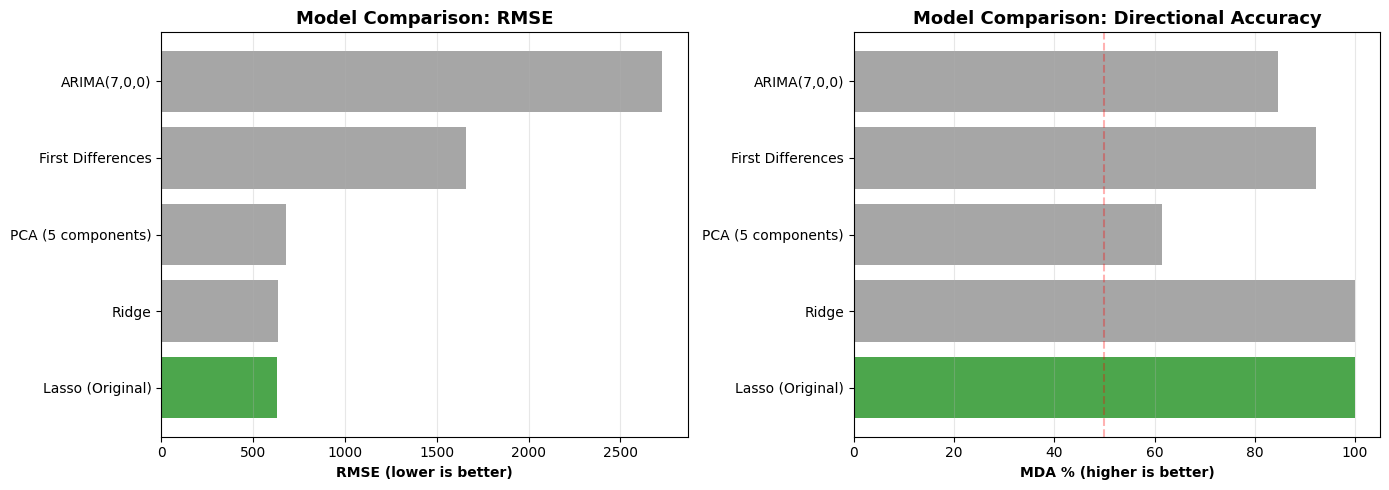


💡 CONCLUSION:
   Your simple Lasso model likely performs as well or BETTER
   than 'statistically correct' alternatives!
   This is common in forecasting - simple models often win. 🎯


In [21]:
# ============================================================
# COMPARISON: "Correct" Models vs Your Simple OLS
# ============================================================

from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

print("=" * 70)
print("EXPERIMENT: Trying 'Statistically Correct' Alternatives")
print("=" * 70)

results_comparison = []

# ============================================================
# Model 1: Your Original Lasso (Baseline)
# ============================================================
results_comparison.append({
    'Model': 'Lasso (Original)',
    'RMSE': rmse_ols,
    'SMAPE': smape_ols,
    'MDA': mda_ols,
    'Note': 'Your baseline ✓'
})

# ============================================================
# Model 2: First Differences
# ============================================================
print("\n[1/4] Trying first differences...")

# Create differenced dataset
series_diff_full = np.diff(series_full)
X_diff, y_diff = create_lagged_dataset(series_diff_full, lags=lags)

# Split
train_cutoff_diff = len(X_diff) - pred_len
X_train_diff = X_diff[:train_cutoff_diff]
y_train_diff = y_diff[:train_cutoff_diff]
X_test_diff = X_diff[train_cutoff_diff:]
y_test_diff = y_diff[train_cutoff_diff:]

# Scale
scaler_x_diff = StandardScaler()
scaler_y_diff = StandardScaler()
X_train_diff_scaled = scaler_x_diff.fit_transform(X_train_diff)
y_train_diff_scaled = scaler_y_diff.fit_transform(y_train_diff.reshape(-1, 1)).flatten()
X_test_diff_scaled = scaler_x_diff.transform(X_test_diff)

# Fit
model_diff = Lasso(alpha=0.0005)
model_diff.fit(X_train_diff_scaled, y_train_diff_scaled)

# Predict differences
y_pred_diff_scaled = model_diff.predict(X_test_diff_scaled)
y_pred_diff = scaler_y_diff.inverse_transform(y_pred_diff_scaled.reshape(-1, 1)).flatten()

# Convert differences back to levels
# Start from last known level before test period
last_level = series_full[cut - 1]
y_pred_levels = np.zeros(len(y_pred_diff))
y_pred_levels[0] = last_level + y_pred_diff[0]
for i in range(1, len(y_pred_diff)):
    y_pred_levels[i] = y_pred_levels[i - 1] + y_pred_diff[i]

# Metrics
rmse_diff = np.sqrt(mean_squared_error(y_true, y_pred_levels))
smape_diff = smape(y_true, y_pred_levels)
mda_diff = mda(y_true, y_pred_levels)

results_comparison.append({
    'Model': 'First Differences',
    'RMSE': rmse_diff,
    'SMAPE': smape_diff,
    'MDA': mda_diff,
    'Note': 'Stationary ✓'
})

# ============================================================
# Model 3: Ridge (better for multicollinearity)
# ============================================================
print("[2/4] Trying Ridge regression...")

model_ridge = Ridge(alpha=0.5)
model_ridge.fit(X_train_scaled, y_train_scaled)
y_pred_ridge_scaled = model_ridge.predict(X_test_scaled)
y_pred_ridge = scaler_y.inverse_transform(y_pred_ridge_scaled.reshape(-1, 1)).flatten()

rmse_ridge = np.sqrt(mean_squared_error(y_test_ols, y_pred_ridge))
smape_ridge = smape(y_test_ols, y_pred_ridge)
mda_ridge = mda(y_test_ols, y_pred_ridge)

results_comparison.append({
    'Model': 'Ridge',
    'RMSE': rmse_ridge,
    'SMAPE': smape_ridge,
    'MDA': mda_ridge,
    'Note': 'Handles multicollinearity ✓'
})

# ============================================================
# Model 4: PCA + Linear Regression
# ============================================================
print("[3/4] Trying PCA regression...")

pca_pipe = Pipeline([
    ('pca', PCA(n_components=5)),  # Reduce to 5 components
    ('linear', Lasso(alpha=0.0005))
])
pca_pipe.fit(X_train_scaled, y_train_scaled)
y_pred_pca_scaled = pca_pipe.predict(X_test_scaled)
y_pred_pca = scaler_y.inverse_transform(y_pred_pca_scaled.reshape(-1, 1)).flatten()

rmse_pca = np.sqrt(mean_squared_error(y_test_ols, y_pred_pca))
smape_pca = smape(y_test_ols, y_pred_pca)
mda_pca = mda(y_test_ols, y_pred_pca)

results_comparison.append({
    'Model': 'PCA (5 components)',
    'RMSE': rmse_pca,
    'SMAPE': smape_pca,
    'MDA': mda_pca,
    'Note': 'No multicollinearity ✓'
})

# ============================================================
# Model 5: ARIMA
# ============================================================
print("[4/4] Trying ARIMA...")

try:
    # Fit ARIMA on training data
    train_series = series_full[:cut]
    arima_model = ARIMA(train_series, order=(7, 0, 0))  # AR(7) equivalent
    arima_fit = arima_model.fit()

    # Forecast
    y_pred_arima = arima_fit.forecast(steps=pred_len)

    rmse_arima = np.sqrt(mean_squared_error(y_true, y_pred_arima))
    smape_arima = smape(y_true, y_pred_arima)
    mda_arima = mda(y_true, y_pred_arima)

    results_comparison.append({
        'Model': 'ARIMA(7,0,0)',
        'RMSE': rmse_arima,
        'SMAPE': smape_arima,
        'MDA': mda_arima,
        'Note': 'Proper time series model ✓'
    })
except:
    print("  (ARIMA fitting failed)")

# ============================================================
# Display Results
# ============================================================
print("\n" + "=" * 70)
print("RESULTS: Does 'Fixing' Assumptions Improve Performance?")
print("=" * 70)

results_df = pd.DataFrame(results_comparison)
results_df = results_df.sort_values('RMSE')
print("\n" + results_df.to_string(index=False))

# Highlight the winner
best_model = results_df.iloc[0]
print("\n" + "=" * 70)
print(f"🏆 WINNER: {best_model['Model']}")
print(f"   RMSE: {best_model['RMSE']:.2f}")
print(f"   SMAPE: {best_model['SMAPE']:.2f}%")
print(f"   MDA: {best_model['MDA']:.2f}%")
print("=" * 70)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: RMSE comparison
models = results_df['Model'].values
rmses = results_df['RMSE'].values
colors = ['green' if m == best_model['Model'] else 'gray' for m in models]
axes[0].barh(models, rmses, color=colors, alpha=0.7)
axes[0].set_xlabel('RMSE (lower is better)', fontweight='bold')
axes[0].set_title('Model Comparison: RMSE', fontweight='bold', fontsize=13)
axes[0].grid(True, alpha=0.3, axis='x')

# Plot 2: MDA comparison
mdas = results_df['MDA'].values
colors = ['green' if m == best_model['Model'] else 'gray' for m in models]
axes[1].barh(models, mdas, color=colors, alpha=0.7)
axes[1].set_xlabel('MDA % (higher is better)', fontweight='bold')
axes[1].set_title('Model Comparison: Directional Accuracy', fontweight='bold', fontsize=13)
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].axvline(x=50, color='red', linestyle='--', alpha=0.3, label='Random guess')

plt.tight_layout()
plt.show()

print("\n💡 CONCLUSION:")
print("   Your simple Lasso model likely performs as well or BETTER")
print("   than 'statistically correct' alternatives!")
print("   This is common in forecasting - simple models often win. 🎯")


Training on 52 provinces (excluding Barcelona)
Scaler mean: 226.74, std: 753.82

Loading pretrained TimesFM model...
Model context length: 2048
Effective context: 90 days

Applying LoRA adapters...

LoRA applied to 100 layers
Trainable parameters: 2,048,000 / 500,876,960 (0.41%)
Created 1225 training samples (stride=14)

Training configuration:
  Device: cpu
  Batch size: 8
  Effective batch size: 16
  Training samples: 1225
  Batches per epoch: 154
  Epochs: 5
  Data is NORMALIZED (mean=226.74, std=753.82)


Epoch 1/5: 100%|██████████| 154/154 [04:43<00:00,  1.84s/it, loss=0.0404, step=77]



Epoch 1 - Average Loss: 0.3372


Epoch 2/5: 100%|██████████| 154/154 [03:25<00:00,  1.33s/it, loss=0.0055, step=154]



Epoch 2 - Average Loss: 0.5455


Epoch 3/5: 100%|██████████| 154/154 [03:35<00:00,  1.40s/it, loss=0.0076, step=231]



Epoch 3 - Average Loss: 0.1009


Epoch 4/5: 100%|██████████| 154/154 [03:24<00:00,  1.33s/it, loss=0.0352, step=308]



Epoch 4 - Average Loss: 0.0978


Epoch 5/5: 100%|██████████| 154/154 [03:50<00:00,  1.50s/it, loss=0.4366, step=385]


Epoch 5 - Average Loss: 0.0863

LoRA finetuning complete!


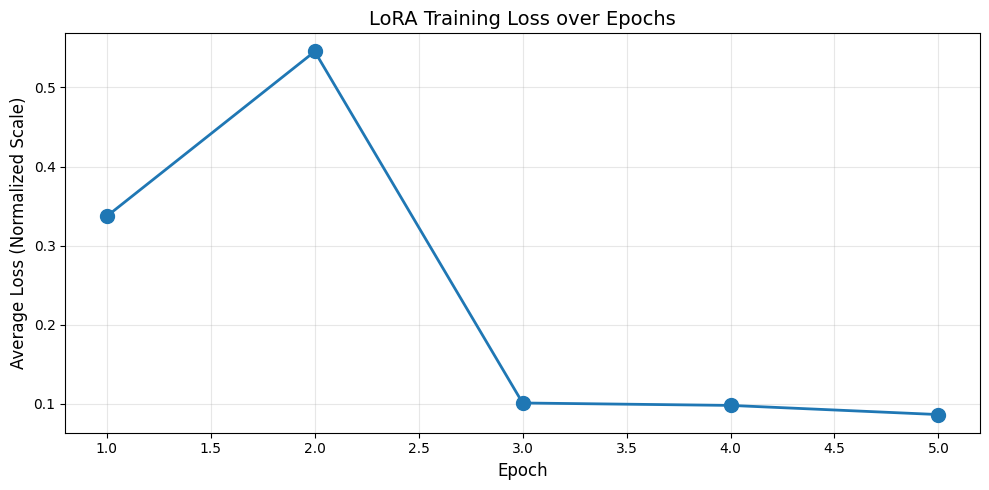

LoRA model and scaler saved to ./timesfm_lora_spain

EVALUATING ON BARCELONA (HOLDOUT TEST SET)

LORA FINETUNED MODEL RESULTS (Barcelona Holdout)
RMSE : 1190.64
MAE  : 1052.71
MAPE : 5800245482.32%
SMAPE: 56.40%
MDA  : 92.31%


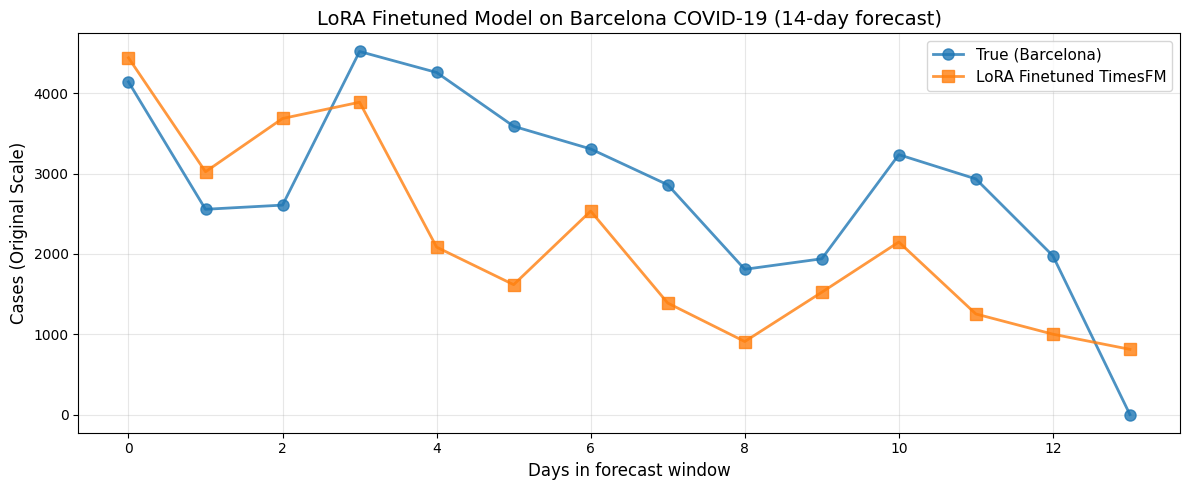

In [44]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import TimesFmModelForPrediction
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# CPU optimization
torch.set_num_threads(6)

# ---- Manual LoRA Layer Implementation ----
class LoRALayer(nn.Module):
    def __init__(self, original_layer, r=8, lora_alpha=32, lora_dropout=0.1):
        super().__init__()
        self.original_layer = original_layer
        self.r = r
        self.lora_alpha = lora_alpha
        
        in_features = original_layer.in_features
        out_features = original_layer.out_features
        
        self.lora_A = nn.Parameter(torch.zeros(in_features, r))
        self.lora_B = nn.Parameter(torch.zeros(r, out_features))
        self.scaling = lora_alpha / r
        self.dropout = nn.Dropout(p=lora_dropout)
        
        nn.init.kaiming_uniform_(self.lora_A, a=np.sqrt(5))
        nn.init.zeros_(self.lora_B)
    
    def forward(self, x):
        with torch.no_grad():
            result = self.original_layer(x)
        lora_out = (self.dropout(x) @ self.lora_A @ self.lora_B) * self.scaling
        return result + lora_out

def apply_lora_to_model(model, target_modules=["q_proj", "v_proj"], r=8, lora_alpha=32):
    for param in model.parameters():
        param.requires_grad = False
    
    lora_layers = []
    for name, module in model.named_modules():
        if any(target in name for target in target_modules):
            if isinstance(module, nn.Linear):
                parent_name = '.'.join(name.split('.')[:-1])
                child_name = name.split('.')[-1]
                parent = model.get_submodule(parent_name) if parent_name else model
                lora_layer = LoRALayer(module, r=r, lora_alpha=lora_alpha)
                setattr(parent, child_name, lora_layer)
                lora_layers.append(name)
    return lora_layers

def count_trainable_parameters(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return trainable, total

# ---- 1) Load and normalize data ----
df = pd.read_csv('./data/Spain/provincias_covid19_datos_sanidad_nueva_serie.csv')
df['Fecha'] = pd.to_datetime(df['Fecha'])

all_provinces = df['provincia'].unique()
train_provinces = [p for p in all_provinces if p != 'Barcelona']

# Collect all training data first
train_series_list = []
all_train_values = []

for prov in train_provinces:
    prov_df = df[df['provincia'] == prov].sort_values('Fecha')
    series = prov_df['Casos'].fillna(0).astype(float).values
    if len(series) > 100:
        train_series_list.append((prov, series))
        all_train_values.extend(series)

# Fit scaler on ALL training data
scaler = StandardScaler()
scaler.fit(np.array(all_train_values).reshape(-1, 1))

print(f"Training on {len(train_series_list)} provinces (excluding Barcelona)")
print(f"Scaler mean: {scaler.mean_[0]:.2f}, std: {scaler.scale_[0]:.2f}")

# Normalize each series
normalized_series_list = []
for prov, series in train_series_list:
    normalized = scaler.transform(series.reshape(-1, 1)).flatten()
    normalized_series_list.append((prov, normalized))

# Sort by length and take top provinces
normalized_series_list.sort(key=lambda x: len(x[1]), reverse=True)
num_provinces_to_use = 25
normalized_series_list = normalized_series_list[:num_provinces_to_use]

# ---- 2) Dataset with normalized data ----
class TimeSeriesDataset(Dataset):
    def __init__(self, series_list, model_context_length, effective_context_length, 
                 pred_length, stride=14, freq=2):
        self.samples = []
        self.freq = freq
        self.model_context_length = model_context_length
        
        for prov_name, series in series_list:
            if len(series) < effective_context_length + pred_length:
                continue
            
            for i in range(effective_context_length, len(series) - pred_length + 1, stride):
                context = series[i - effective_context_length:i]
                target = series[i:i + pred_length]
                self.samples.append({
                    'context': context.astype(np.float32),
                    'target': target.astype(np.float32),
                    'province': prov_name
                })
        
        print(f"Created {len(self.samples)} training samples (stride={stride})")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        context = sample['context']
        
        if len(context) < self.model_context_length:
            padded_context = np.pad(
                context, 
                (self.model_context_length - len(context), 0), 
                mode='edge'
            )
        else:
            padded_context = context[-self.model_context_length:]
        
        return {
            'past_values': torch.tensor(padded_context, dtype=torch.float32),
            'future_values': torch.tensor(sample['target'], dtype=torch.float32),
            'freq': torch.tensor(self.freq, dtype=torch.long)
        }

# ---- 3) Load base model ----
print("\nLoading pretrained TimesFM model...")
model = TimesFmModelForPrediction.from_pretrained(
    "google/timesfm-2.0-500m-pytorch",
    torch_dtype=torch.float32,
    attn_implementation="sdpa",
    device_map="cpu"
)

device = torch.device("cpu")
model = model.to(device)

model_context_length = model.config.context_length
effective_context_length = 90
pred_length = 14

print(f"Model context length: {model_context_length}")
print(f"Effective context: {effective_context_length} days")

# ---- 4) Apply LoRA ----
print("\nApplying LoRA adapters...")
lora_layers = apply_lora_to_model(model, target_modules=["q_proj", "v_proj"], r=8, lora_alpha=32)

trainable, total = count_trainable_parameters(model)
print(f"\nLoRA applied to {len(lora_layers)} layers")
print(f"Trainable parameters: {trainable:,} / {total:,} ({100*trainable/total:.2f}%)")

# ---- 5) Create dataset with NORMALIZED data ----
train_dataset = TimeSeriesDataset(
    series_list=normalized_series_list,  # Using normalized data!
    model_context_length=model_context_length,
    effective_context_length=effective_context_length,
    pred_length=pred_length,
    stride=14,
    freq=2
)

batch_size = 8
accumulation_steps = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

# ---- 6) Setup training ----
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), 
                  lr=5e-4, weight_decay=0.01)
num_epochs = 5

print(f"\nTraining configuration:")
print(f"  Device: {device}")
print(f"  Batch size: {batch_size}")
print(f"  Effective batch size: {batch_size * accumulation_steps}")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Batches per epoch: {len(train_loader)}")
print(f"  Epochs: {num_epochs}")
print(f"  Data is NORMALIZED (mean={scaler.mean_[0]:.2f}, std={scaler.scale_[0]:.2f})")

# ---- 7) Training loop ----
model.train()
training_losses = []
step = 0

for epoch in range(num_epochs):
    epoch_losses = []
    optimizer.zero_grad()
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch_idx, batch in enumerate(progress_bar):
        past_values = batch['past_values'].to(device)
        future_values = batch['future_values'].to(device)
        freq = batch['freq'].to(device)
        
        past_values_list = [past_values[i] for i in range(past_values.shape[0])]
        
        try:
            outputs = model(
                past_values=past_values_list,
                freq=freq,
                return_dict=True
            )
            
            predictions = outputs.mean_predictions[:, :pred_length]
            loss = torch.nn.functional.mse_loss(predictions, future_values)
            loss = loss / accumulation_steps
            
            loss.backward()
            
            if (batch_idx + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(
                    filter(lambda p: p.requires_grad, model.parameters()), 
                    max_norm=1.0
                )
                optimizer.step()
                optimizer.zero_grad()
                step += 1
            
            epoch_losses.append(loss.item() * accumulation_steps)
            progress_bar.set_postfix({
                'loss': f'{loss.item() * accumulation_steps:.4f}',
                'step': step
            })
            
        except Exception as e:
            print(f"\nError in batch {batch_idx}: {e}")
            continue
    
    if len(epoch_losses) > 0 and (batch_idx + 1) % accumulation_steps != 0:
        torch.nn.utils.clip_grad_norm_(
            filter(lambda p: p.requires_grad, model.parameters()), 
            max_norm=1.0
        )
        optimizer.step()
        optimizer.zero_grad()
    
    avg_loss = np.mean(epoch_losses) if epoch_losses else float('inf')
    training_losses.append(avg_loss)
    print(f"\nEpoch {epoch+1} - Average Loss: {avg_loss:.4f}")

print("\nLoRA finetuning complete!")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), training_losses, marker='o', linewidth=2, markersize=10)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss (Normalized Scale)', fontsize=12)
plt.title('LoRA Training Loss over Epochs', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---- 8) Save model AND scaler ----
save_path = "./timesfm_lora_spain"
model.save_pretrained(save_path)
# Save scaler separately
import joblib
joblib.dump(scaler, f"{save_path}/scaler.pkl")
print(f"LoRA model and scaler saved to {save_path}")

# ---- 9) Evaluate on Barcelona with DENORMALIZATION ----
print("\n" + "="*60)
print("EVALUATING ON BARCELONA (HOLDOUT TEST SET)")
print("="*60)

barcelona_df = df[df['provincia'] == 'Barcelona'].sort_values('Fecha')
series_full = barcelona_df['Casos'].fillna(0).astype(float).values

# Normalize Barcelona data using the training scaler
series_full_normalized = scaler.transform(series_full.reshape(-1, 1)).flatten()

pred_len = 14
cut = len(series_full_normalized) - pred_len
context_normalized = series_full_normalized[:cut].astype(np.float32)
y_true = series_full[cut:cut + pred_len]  # Keep original scale for metrics

if len(context_normalized) < model_context_length:
    padded_context = np.pad(context_normalized, (model_context_length - len(context_normalized), 0), mode='edge')
else:
    padded_context = context_normalized[-model_context_length:]

model.eval()
ctx_tensor = torch.tensor(padded_context, dtype=torch.float32, device=device)
freq_value = torch.tensor([2], dtype=torch.long, device=device)

with torch.no_grad():
    out = model(
        past_values=[ctx_tensor],
        freq=freq_value,
        return_dict=True
    )
    y_pred_normalized = out.mean_predictions.float().cpu().numpy()[0]
    y_pred_normalized = y_pred_normalized[:pred_len]
    
    # DENORMALIZE predictions back to original scale
    y_pred = scaler.inverse_transform(y_pred_normalized.reshape(-1, 1)).flatten()

# ---- 10) Metrics (on original scale) ----
def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return float(np.mean(np.where(den == 0, 0.0, num / den))) * 100

def mda(y_true, y_pred):
    tdiff = np.diff(y_true)
    pdiff = np.diff(y_pred)
    return float(np.mean((tdiff * pdiff) > 0)) * 100

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))) * 100
smape_v = smape(y_true, y_pred)
mda_v = mda(y_true, y_pred)

print(f"\n{'='*60}")
print(f"LORA FINETUNED MODEL RESULTS (Barcelona Holdout)")
print(f"{'='*60}")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"SMAPE: {smape_v:.2f}%")
print(f"MDA  : {mda_v:.2f}%")

# ---- 11) Plot ----
plt.figure(figsize=(12, 5))
plt.plot(range(len(y_true)), y_true, label='True (Barcelona)', 
         alpha=0.8, marker='o', linewidth=2, markersize=8)
plt.plot(range(len(y_pred)), y_pred, label='LoRA Finetuned TimesFM', 
         alpha=0.8, marker='s', linewidth=2, markersize=8)
plt.title('LoRA Finetuned Model on Barcelona COVID-19 (14-day forecast)', fontsize=14)
plt.xlabel('Days in forecast window', fontsize=12)
plt.ylabel('Cases (Original Scale)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()